# Create dataset for prototype

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
import cv2
from tqdm import tqdm
import torchvision
from random import shuffle
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from torchvision.models import resnet18
from torch import nn, optim
from torch.utils.data import Dataset
from scipy.spatial import Delaunay

# Data prep

In [3]:

################# Load data #################
# open .pt image tensor
heatmaps = torch.load('data/anotated_MNIST/heatmaps/heatmaps_01.pt')
# open .pt label tensor
labels = torch.load('data/anotated_MNIST/raw/labels_01.pt')
# open .pt image tensor
images = torch.load('data/anotated_MNIST/raw/images_01.pt')

concepts = torch.load('data/anotated_MNIST/raw/concept_labels_01.pt')

################# Crop images #################
cropped_images = []
for i in tqdm(range(len(heatmaps))):
    # find min and max x,y values of the heap that are not 0
    heat = heatmaps[i].squeeze().numpy()
    image = images[i].squeeze().numpy()

    for i in range(heat.shape[0]):
        if sum(heat[i]) > 100:
            min_x = i
            break
    for i in range(heat.shape[0]-1, 0, -1):
        if sum(heat[i]) > 100:
            max_x = i
            break
    for i in range(heat.shape[1]):
        if sum(heat[:,i]) > 100:
            min_y = i
            break
    for i in range(heat.shape[1]-1, 0, -1):
        if sum(heat[:,i]) > 100:
            max_y = i
            break

    bouding_box = (min_x, max_x, min_y, max_y)
    # crop image based on bounding box
    cropped_image = image[min_x:max_x, min_y:max_y]

    cropped_images.append(cropped_image)
    # # save cropped image
    # cv2.imwrite('data/anotated_MNIST/cropped_images/{}.jpg'.format(i), cropped_image)
# reshape to 40x40 images
cropped_images_reshaped = []
for i in range(len(cropped_images)):
    cropped_images_reshaped.append(cv2.resize(cropped_images[i], (40, 40)))
cropped_images_reshaped = np.array(cropped_images_reshaped)

100%|██████████| 300/300 [00:00<00:00, 638.88it/s]


In [4]:
# sort images by labels index
sorted_images = []
sorted_labels = []
sorted_concepts = []

for i in range(10):
    for j in range(len(labels)):
        if labels[j] == i:
            sorted_images.append(cropped_images_reshaped[j])
            sorted_labels.append(labels[j])
            sorted_concepts.append(concepts[j])

In [5]:
N_WAY = 4  # Number of classes in a task
N_SHOT = 13  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

In [ ]:
# locate

In [50]:
plotting_images = sorted_images[4:]
plotting_labels = sorted_labels[4:]

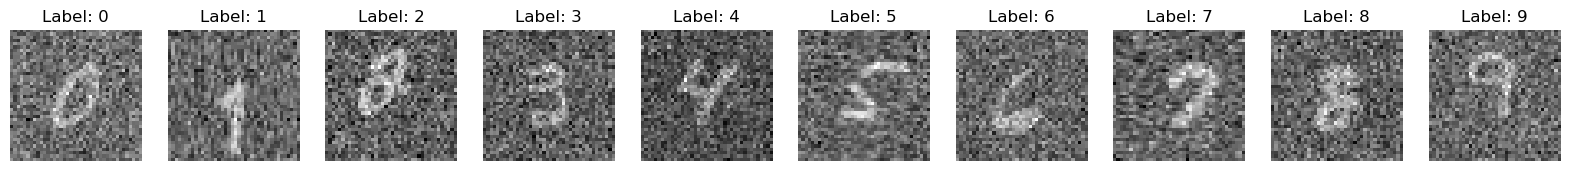

In [59]:
# plot images
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
counter = 0
for i in range(len(plotting_images)):
    if counter == plotting_labels[i]:
        ax[counter].imshow(plotting_images[i], cmap='gray')
        ax[counter].set_title("Label: " + str(plotting_labels[i]))
        ax[counter].axis('off')
        counter += 1
    if counter == 10:
        break
plt.savefig('img/cropped_images.pdf', dpi=300)
plt.show()


In [6]:
images = []
labels = []
class_ids = []
# take first N_WAY classes
for i in range(N_WAY):
    # take N_SHOT images from each class
    counter = 0
    for j, image in enumerate(sorted_images):
        # get label
        label = sorted_labels[j]
        if label == i:
            images.append(image)
            labels.append(label)
            class_ids.append(j)
            counter += 1

In [7]:
class FSLDataset(Dataset):
    # defining values in the constructor
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform

    # Getting the data samples
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)    
        sample = img, self.labels[idx]
        return sample

    # Getting data size/length
    def __len__(self):
        return self.len

In [8]:
image_size = 40
fsd_test = FSLDataset(
    torch.tensor(images).unsqueeze(1).float(),
    labels
    )
fsd_test.get_labels = lambda: labels

test_sampler = TaskSampler(
    fsd_test, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)
test_DataLoader = torch.utils.data.DataLoader(fsd_test,
                                              batch_size=1,
                                              batch_sampler=test_sampler,
                                              pin_memory=True,
                                              collate_fn=test_sampler.episodic_collate_fn,
                                              )

/var/folders/5l/_0j09j5n0gg7s_98h1l1nvw40000gn/T/ipykernel_18211/1362776204.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1671696763866/work/torch/csrc/utils/tensor_new.cpp:253.)
  torch.tensor(images).unsqueeze(1).float(),


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


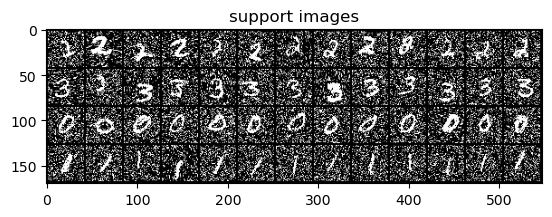

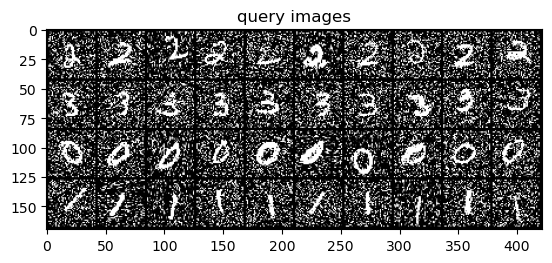

In [9]:
for x in test_DataLoader:
    (
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
    ) = x
    break

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Model creation and training

In [10]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

from models.model import CNN
cnn = CNN()
# load state dict
# colenet5.load_state_dict(torch.load('/Users/blazdobravec/Documents/FACULTY/DOC/RW1/PERSONAL/attention_concept/saved_models/LeNet5/model11.pt', map_location=torch.device('cpu')))

convolutional_network = resnet18(pretrained=True)
# colenet5.fc = nn.Flatten()
print(cnn)

model = PrototypicalNetworks(cnn).to("cpu")

/Users/blazdobravec/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/blazdobravec/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNN(
  (conv): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4563, out_features=128, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
model.eval()
example_scores = model(
    example_support_images.to("cpu"),
    example_support_labels.to("cpu"),
    example_query_images.to("cpu"),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

# print("Ground Truth / Predicted")
# for i in range(len(example_query_labels)):
#     print(f"{example_class_ids[example_query_labels[i]]} / {example_class_ids[example_predicted_labels[i]]}")

In [12]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.to("cpu"), support_labels.to("cpu"), query_images.to("cpu"))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to("cpu")
    ).sum().item(), len(query_labels)


def evaluate(data_loader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_DataLoader)

100%|██████████| 100/100 [00:00<00:00, 170.81it/s]

Model tested on 100 tasks. Accuracy: 41.00%


# training deluney_features

In [13]:
labels = torch.load('data/anotated_MNIST/raw/labels_01.pt')
all_features = []
for i in tqdm(range(len(cropped_images_reshaped))):
    threshold = 1.4
    example = cropped_images_reshaped[i]
    label = labels[i]
    # for each treshold do a deluneay triangulation and count the number of triangles
    # if the number of triangles is less than 1000 then the threshold is too low
    # if the number of triangles is more than 1000 then the threshold is too high
    # if the number of triangles is 1000 then the threshold is just right
    points = []
    y = 0
    for row in example:
        x = 0
        for el in row:
            points.append(np.array([[x, y], el]))
            x += 1
        y += 1
    # drop points with activation less than threshold
    points = np.array(points)
    points_cropped = points[points[:,1].astype(float) > threshold]
    points_cropped = list(map(lambda x: x, points_cropped[:,0]))
    tri = Delaunay(points_cropped)
    
    # fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # axs[0].imshow(example, cmap='gray')
    # axs[0].set_title(label)
    # axs[1].triplot(list(map(lambda x: x[0], points_cropped)), list(map(lambda x: x[1], points_cropped)), tri.simplices.copy())
    # axs[1].plot(list(map(lambda x: x[0], points_cropped)), list(map(lambda x: x[1], points_cropped)), 'o')
    # axs[1].set_aspect('equal', 'box')
    # plt.show()
    
    lines = []
    for i in range(len(tri.simplices)):
        for j in range(len(tri.simplices[i])):
            if j == 2:
                lines.append([tri.simplices[i][j], tri.simplices[i][0]])
            else:
                lines.append([tri.simplices[i][j], tri.simplices[i][j+1]])
    
    # extract features
    shuffle(lines)
    elem_features = []
    for i in range(len(lines)):
        start, end = tri.points[lines[i]]
        # calculate the length of the line
        length = np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
        if length < 2.5 and len(elem_features) < 170:
            start = start / 40
            end = end / 40
            elem_features.append([start[0], end[0], start[1], end[1]])
    all_features.append((label, elem_features))

  0%|          | 0/300 [00:00<?, ?it/s]/var/folders/5l/_0j09j5n0gg7s_98h1l1nvw40000gn/T/ipykernel_18211/4155057883.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points.append(np.array([[x, y], el]))
100%|██████████| 300/300 [00:02<00:00, 131.30it/s]


In [14]:
# sort the features by label
all_features = sorted(all_features, key=lambda x: x[0])

In [15]:
image_features = []
labels = []
class_ids = []
# take first N_WAY classes
for i in range(N_WAY):
    # take N_SHOT images from each class
    for j, (label, image_feature) in enumerate(all_features):
        # flatten image feature
        image_feature = [item for sublist in image_feature for item in sublist]
        if label == i:
            image_features.append(image_feature)
            labels.append(label)
            class_ids.append(j)

In [16]:
for features in image_features:
    if len(features) < 680:
        print(len(features))

In [17]:
class FSLDataset(Dataset):
    # defining values in the constructor
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    # Getting the data samples
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)    
        sample = img, self.labels[idx]
        return sample
    
    # Getting data size/length
    def __len__(self):
        return self.len

In [18]:
image_size = 40
fsd_test = FSLDataset(
    torch.tensor(image_features).unsqueeze(1).float(),
    labels
    )
fsd_test.get_labels = lambda: labels

test_sampler = TaskSampler(
    fsd_test, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)
test_DataLoader = torch.utils.data.DataLoader(fsd_test,
                                              batch_size=1,
                                              batch_sampler=test_sampler,
                                              pin_memory=True,
                                              collate_fn=test_sampler.episodic_collate_fn,
                                              )

In [19]:
for x in test_DataLoader:
    (
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
    ) = x
    break



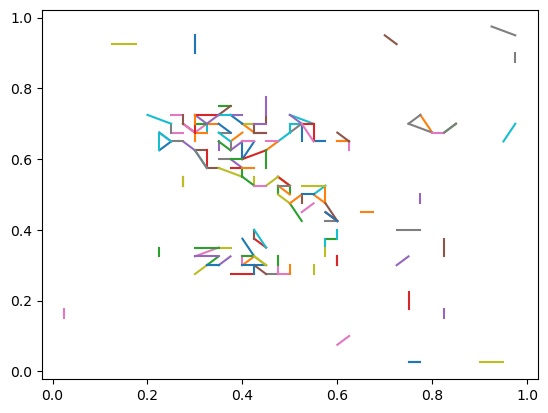

In [20]:
# itterate over example_support_images and take every 4 values and use them as a line

for i in range(0, len(example_support_images[0][0]), 4):
    start = [example_support_images[0][0][i], example_support_images[0][0][i+2]]
    end = [example_support_images[0][0][i+1], example_support_images[0][0][i+3]]
    plt.plot([start[0], end[0]], [start[1], end[1]])
plt.show()

In [21]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
        ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [z_support[torch.nonzero(support_labels == label)].mean(0) for label in range(n_way)]
        )

        # reshape to switch dim 0 and 1
        z_proto = z_proto.reshape(n_way, -1)
        z_query = z_query.reshape(-1, z_query.shape[-1])

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)
        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

from models.model import CNN, ConSim
conSim = ConSim()
# load state dict
# colenet5.load_state_dict(torch.load('/Users/blazdobravec/Documents/FACULTY/DOC/RW1/PERSONAL/attention_concept/saved_models/LeNet5/model11.pt', map_location=torch.device('cpu')))

# convolutional_network = resnet18(pretrained=True)
# # colenet5.fc = nn.Flatten()
# print(convolutional_network)

model = PrototypicalNetworks(conSim).to("cpu")

In [22]:
model.eval()
example_scores = model(
    example_support_images.to("cpu"),
    example_support_labels.to("cpu"),
    example_query_images.to("cpu"),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

In [23]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
):
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.to("cpu"), support_labels.to("cpu"), query_images.to("cpu"))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to("cpu")
    ).sum().item(), len(query_labels)


def evaluate(data_loader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_DataLoader)

100%|██████████| 100/100 [00:00<00:00, 409.18it/s]

Model tested on 100 tasks. Accuracy: 24.35%


# training a meta learning model

In [24]:
model

PrototypicalNetworks(
  (backbone): ConSim(
    (fc1): Linear(in_features=680, out_features=1024, bias=True)
    (act1): ReLU()
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (act2): ReLU()
    (fc3): Linear(in_features=512, out_features=256, bias=True)
    (act3): ReLU()
    (fc4): Linear(in_features=256, out_features=128, bias=True)
    (act4): ReLU()
    (fc5): Linear(in_features=128, out_features=64, bias=True)
    (act5): ReLU()
    (fc6): Linear(in_features=64, out_features=32, bias=True)
    (act6): ReLU()
    (fc7): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [25]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

image_size = 40
# shuffle images
np.random.shuffle(images)

fsd_train = FSLDataset(
    torch.tensor(images).unsqueeze(1).float(),
    labels
    )
fsd_train.get_labels = lambda: labels

train_sampler = TaskSampler(
    fsd_train, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_DataLoader = torch.utils.data.DataLoader(fsd_train,
                                              batch_size=1,
                                              batch_sampler=train_sampler,
                                              pin_memory=True,
                                              collate_fn=train_sampler.episodic_collate_fn,
                                              )

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
    ) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.to("cpu"), support_labels.to("cpu"), query_images.to("cpu")
    )

    loss = criterion(classification_scores, query_labels.to("cpu"))
    loss.backward()
    optimizer.step()

    return loss.item()

In [27]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_DataLoader), total=len(train_DataLoader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  0%|          | 0/40000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2080x40 and 680x1024)

In [71]:
# Evaluate the model on the validation set
evaluate(test_DataLoader)

100%|██████████| 100/100 [00:00<00:00, 151.79it/s]

Model tested on 100 tasks. Accuracy: 27.15%
